# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [1]:
# Install required packages
#%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

2025-05-14 07:19:34.360602: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 07:19:34.646097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 07:19:34.819959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747207174.972994    2383 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747207175.016090    2383 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747207175.267692    2383 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Data Loading and Preprocessing

2025-05-14 07:20:03.379824: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-14 07:20:03.532925: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-14 07:20:27.261326: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 07:20:48.519042: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


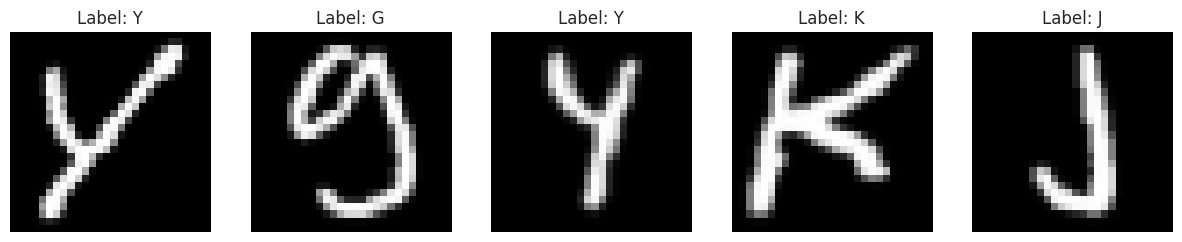

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

# Load EMNIST Letters dataset as supervised pairs (image, label)
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Convert tf.data.Dataset to NumPy arrays
def convert_to_numpy(ds):
    x = []
    y = []
    for image, label in tfds.as_numpy(ds):
        x.append(image)
        y.append(label)
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = convert_to_numpy(ds_train)
x_test, y_test = convert_to_numpy(ds_test)

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(x_train[i].squeeze()), cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [3]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


## 2. Model Implementation

### TensorFlow/Keras Implementation

In [7]:
# Create CNN using Keras
from keras import layers
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3,), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2,)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(), 
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')              
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create and compile model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,994 (890.60 KB)

 Trainable params: 227,546 (888.85 KB)

 Non-trainable params: 448 (1.75 KB)

## 3. Training and Evaluation

### TensorFlow/Keras Training

Epoch 1/20


2025-05-14 07:28:41.224748: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 222781440 exceeds 10% of free system memory.


2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6439 - loss: 1.2417

2025-05-14 07:29:34.658608: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55695360 exceeds 10% of free system memory.


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - accuracy: 0.6440 - loss: 1.2413 - val_accuracy: 0.8919 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.8502 - loss: 0.4679 - val_accuracy: 0.9185 - val_loss: 0.2481 - learning_rate: 0.0010
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.8742 - loss: 0.3868 - val_accuracy: 0.9198 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.8867 - loss: 0.3465 - val_accuracy: 0.9279 - val_loss: 0.2137 - learning_rate: 0.0010
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.8938 - loss: 0.3229 - val_accuracy: 0.9309 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - accuracy: 0.9008 - loss: 0.2987 - val_accuracy: 0.9338 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - accuracy: 0.9054 

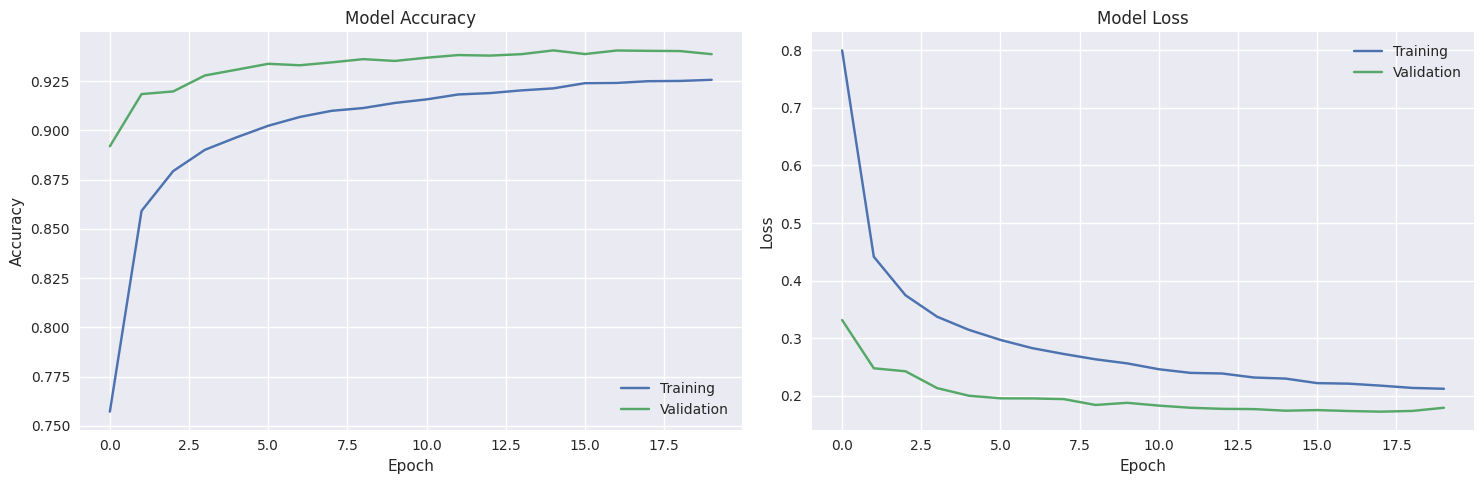

In [8]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### PyTorch Training

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for CNN input
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create CNN with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in CNN layers
   - Solution: Ensure data is properly shaped (samples, height, width, channels)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters